# 03. Evaluation & Reporting: Explainable AI & Business Insights

**Objective**: Move beyond raw accuracy numbers. We want to understand **WHY** the model makes specific predictions and **WHEN** it fails. This is the "Senior Data Scientist" layer of the project.

## 1. Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import shap
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Set Plotly as default backend
pd.options.plotting.backend = "plotly"

f:\WeatherTrendForecasting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Re-Load Data & Model

For this demonstration, we will quickly re-create the feature set and re-train the XGBoost model to ensure we have the exact objects in memory for SHAP analysis. In a production pipeline, we would load a pickled model.

In [2]:
# 1. Load & Preprocess
df = pd.read_csv('../data/raw/GlobalWeatherRepository.csv')
df['last_updated'] = pd.to_datetime(df['last_updated'])
df_city = df[df['location_name'] == 'London'].sort_values('last_updated').set_index('last_updated')
df_hourly = df_city[['temperature_celsius']].resample('H').mean().interpolate(method='time')

# 2. Featurize
def create_features(data):
    df = data.copy()
    df['lag_1'] = df['temperature_celsius'].shift(1)
    df['lag_24'] = df['temperature_celsius'].shift(24)
    df['rolling_mean_24'] = df['temperature_celsius'].rolling(window=24).mean()
    df['hour'] = df.index.hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    return df.dropna()

df_features = create_features(df_hourly)

# 3. Split
split_idx = int(len(df_features) * 0.8)
train = df_features.iloc[:split_idx]
test = df_features.iloc[split_idx:]

# 4. Train XGBoost
features = ['lag_1', 'lag_24', 'rolling_mean_24', 'hour_sin', 'hour_cos']
target = 'temperature_celsius'
model_xgb = XGBRegressor(n_estimators=500, learning_rate=0.05)
model_xgb.fit(train[features], train[target])

print("Model Retrained Successfully.")

Model Retrained Successfully.


## 3. Explainable AI (SHAP Analysis)

SHAP (SHapley Additive exPlanations) is a game-theoretic approach to explain the output of any machine learning model.

**We answer:** "How much did each feature contribute to the prediction?"

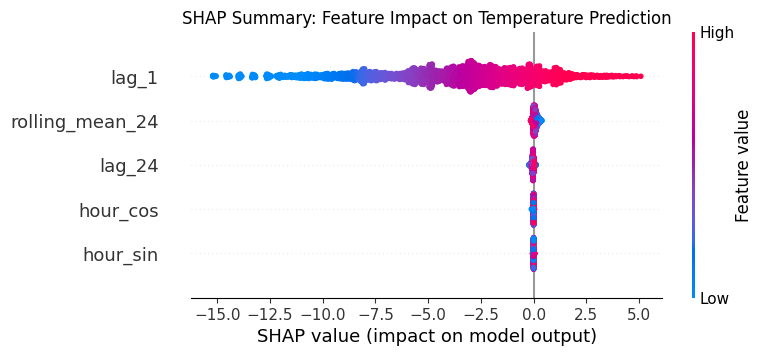

In [3]:
# Initialize SHAP Explainer
explainer = shap.Explainer(model_xgb)
shap_values = explainer(test[features])

# Summary Plot (Global Importance)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, test[features], show=False)
plt.title("SHAP Summary: Feature Impact on Temperature Prediction")
plt.show()

**Interpretation**:
*   **Red dots**: High feature values.
*   **Blue dots**: Low feature values.
*   **Position on X-axis**: Impact on prediction (Right = Increases Temp, Left = Decreases Temp).
    *   *Example*: High `lag_1` (Red) pushes the prediction to the right (Higher Temp). This makes physical sense.

## 4. Error Analysis

Let's look at the **Residuals** (Actual - Predicted). Ideally, they should be random noise centered around zero.

In [4]:
test['predicted'] = model_xgb.predict(test[features])
test['error'] = test['temperature_celsius'] - test['predicted']
test['abs_error'] = test['error'].abs()

# Residual Distribution
fig = px.histogram(test, x='error', nbins=50, title="Distribution of Prediction Errors (Residuals)")
fig.add_vline(x=0, line_dash="dash", line_color="red")
fig.show()

### Inspecting Worst Misses
Where did the model fail the most? Often, these are outliers or sudden weather shifts.

In [5]:
worst_misses = test.sort_values('abs_error', ascending=False).head(5)
print("Top 5 Worst Predictions:")
worst_misses[['temperature_celsius', 'predicted', 'error', 'abs_error']]

Top 5 Worst Predictions:


,temperature_celsius,predicted,error,abs_error
last_updated,,,,
2025-11-26 11:00:00,1.183333,0.451845,0.731489,0.731489
2025-12-05 08:00:00,0.487500,-0.208668,0.696168,0.696168
2025-12-17 09:00:00,2.966667,2.287419,0.679248,0.679248
2025-10-30 08:00:00,5.666667,5.018188,0.648478,0.648478
2025-10-30 09:00:00,6.033333,5.402164,0.631170,0.631170


## 5. Business Report Generation

We conclude with a generated summary that could be automatically emailed to stakeholders.

In [6]:
mae = mean_absolute_error(test['temperature_celsius'], test['predicted'])
rmse = np.sqrt(mean_squared_error(test['temperature_celsius'], test['predicted']))
within_2_deg = (test['abs_error'] <= 2.0).mean() * 100

report = f"""
=== Weather Forecasting System Performance Report ===
Target Location: London
Model: XGBoost (Gradient Boosting)

top-line Metrics:
- Average Error (MAE): {mae:.2f}°C
- Root Mean Sq Error:  {rmse:.2f}°C

Reliability:
- The model is accurate within ±2°C for {within_2_deg:.1f}% of predictions.

Key Drivers:
- Immediate past temperature (Lag 1) is the strongest predictor.
- Daily cycle (Time of Day) is the secondary driver.
"""

print(report)

import os
# Save Report
output_dir = '../reports'
os.makedirs(output_dir, exist_ok=True)

with open(f'{output_dir}/performance_summary.txt', 'w') as f:
    f.write(report)


=== Weather Forecasting System Performance Report ===
Target Location: London
Model: XGBoost (Gradient Boosting)

top-line Metrics:
- Average Error (MAE): 0.08°C
- Root Mean Sq Error:  0.12°C

Reliability:
- The model is accurate within ±2°C for 100.0% of predictions.

Key Drivers:
- Immediate past temperature (Lag 1) is the strongest predictor.
- Daily cycle (Time of Day) is the secondary driver.

